In [3]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
user_info = pd.read_csv("data/user_info.txt", sep="\t", header=None, names=[
    "user_id", "expert_tags", "word_id", "char_id"
])
question_info = pd.read_csv("data/question_info.txt", sep="\t", header=None, names=[
    "question_id", "tag", "word_id", "char_id", "upvotes", "answers", "top_answers"
])

train_info = pd.read_csv("data/invited_info_train.txt", sep="\t", header=None, names=[
    "question_id", "user_id", "answered"
])

safeInt = lambda v: int(v) if v != '' else None
cleanFeature = lambda r: map(safeInt, r.split('/'))

# single time computation
find_max = lambda v: max(cleanFeature(v))
find_min = lambda v: min(cleanFeature(v))

# Computing the parameter ranges to vectorize user parameters
USER_TAG = [0, 142]
# max_expert_tag = user_info['expert_tags'].apply(find_max).max()
# min_expert_tag = user_info['expert_tags'].apply(find_min).min()

USER_WORD_ID = [0, 37809]
# max_word_id = user_info['word_id'].apply(find_max).max()
# min_word_id = user_info['word_id'].apply(find_max).min()

USER_CHAR_ID = [0, 4021]
# max_char_id = user_info['char_id'].apply(find_max).max()
# min_char_id = user_info['char_id'].apply(find_max).max()

QUESTION_TAG = [0, 19]
# max_question_tag = question_info['tag'].max()
# min_question_tag = question_info['tag'].min()

QUESTION_WORD_ID = [0, 13230]
# max_word_id = question_info['word_id'].apply(find_max).max()
# min_word_id = question_info['word_id'].apply(find_max).max()

QUESTION_CHAR_ID = [0, 2958]
# max_char_id = question_info['char_id'].apply(find_max).max()
# min_char_id = question_info['char_id'].apply(find_max).max()

question_info['ease'] = ( question_info['answers'] - question_info['answers'].min()  ) / question_info['answers'].max()
question_info['popularity'] = ( question_info['top_answers'] - question_info['top_answers'].min() ) / question_info['top_answers'].max()
question_info['votability'] = ( question_info['upvotes'] - question_info['upvotes'].min() ) / question_info['upvotes'].max()
question_info['nTag'] = ( question_info['tag'] - question_info['tag'].min() ) / question_info['tag'].max()
question_info['answerability'] = ( question_info['top_answers'] / question_info['answers'] )
question_info['answerability'] =  question_info['answerability'].fillna(0)

# ASKED vs ANSWERED
answered = train_info[ train_info.answered == 1 ].groupby('user_id').count()['answered']
asked = train_info.groupby('user_id').count()['answered'].rename('asked')
user_info = user_info.join(answered, on="user_id", how="left" ).join(asked, on="user_id", how="left" )
user_info['answered'] =  user_info['answered'].fillna(0)
user_info['asked']    =  user_info['asked'].fillna(0)

answered = train_info[ train_info.answered == 1 ].groupby('question_id').count()['answered']
asked = train_info.groupby('question_id').count()['answered'].rename('asked')
question_info = question_info.join(answered, on="question_id", how="left" ).join(asked, on="question_id", how="left")
question_info['answered'] =  question_info['answered'].fillna(0)
question_info['asked']    =  question_info['asked'].fillna(0)

In [5]:
def expand(df):
    row  = [ ]
    col  = [ ]
    data = [ ]
    for i in df.index:
        for e in [x for x in df.ix[i] if x is not None]:
            row.append(i)
            col.append(e)
            data.append(1)  
    return (row, col, data)

def vectorize(ds, column):
    splitFeatures = ds[column].apply(cleanFeature)
    return expand(splitFeatures)

def writeResults(fileName, data):
    f = open("data/" + fileName, "w+")
    for d in data:
        f.write(",".join(map(str, d)))
        f.write("\n")
    f.close()

In [6]:
import libpmf.libpmf as libpmf
from scipy import sparse

def MF(d, column, f1, f2, k=5):
    (row, col, data) = vectorize(d, column)
    V = scipy.sparse.csr_matrix((data, (row, col)))
    model = libpmf.train(V, '-k {0} -l 0.1 -t {0}'.format(k))
    writeResults(f1, model['W'])
    writeResults(f2, model['H'])

MF(user_info, "expert_tags", 'user-expert-latent', 'expert-user-latent', 5)
MF(user_info, "word_id", 'user-word-latent', 'word-user-latent', 10)
MF(user_info, "char_id", 'user-char-latent', 'char-user-latent', 10)
MF(question_info, "word_id", 'question-word-latent', 'word-question-latent', 10)
MF(question_info, "char_id", 'question-char-latent', 'char-question-latent', 10)

libpmf/libpmf.py:60: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if None in [row_idx, col_idx, obs_val, m, n]:


In [7]:
question_word_latent = pd.read_csv("data/question-word-latent", sep=",", header=None, names=[
    "wq1", "wq2", "wq3", "wq4", "wq5", "wq6", "wq7", "wq8", "wq9", "wq10"
])
question_char_latent = pd.read_csv("data/question-char-latent", sep=",", header=None, names=[
    "cq1", "cq2", "cq3", "cq4", "cq5", "cq6", "cq7", "cq8", "cq9", "cq10"
])
question_info = pd.concat([question_info, question_word_latent, question_char_latent], axis=1, join_axes=[question_info.index])

user_word_latent = pd.read_csv("data/user-word-latent", sep=",", header=None, names=[
    "w1", "w2", "w3", "w4", "w5", "w6", "w7", "w8", "w9", "w10"
])
user_char_latent = pd.read_csv("data/user-char-latent", sep=",", header=None, names=[
    "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9", "c10"
])
user_expert_latent = pd.read_csv("data/user-expert-latent", sep=",", header=None, names=[
    "t1", "t2", "t3", "t4", "t5"
])
user_info = pd.concat([user_info, user_word_latent, user_char_latent, user_expert_latent], axis=1, join_axes=[user_info.index])

In [8]:
user_info.index = user_info['user_id']
question_info.index = question_info['question_id']
user_info.to_csv("data/user-features", sep=",", columns=[
    "t1", "t2", "t3", "t4", "t5",
    "w1", "w2", "w3", "w4", "w5", "w6", "w7", "w8", "w9", "w10",
    "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9", "c10",
])
question_info.to_csv("data/question-features", sep=",", columns=[
    "tag", "upvotes", "answers", "top_answers",
    "nTag", "votability", "ease", "popularity", "answerability",
    "wq1", "wq2", "wq3", "wq4", "wq5", "wq6", "wq7", "wq8", "wq9", "wq10",
    "cq1", "cq2", "cq3", "cq4", "cq5", "cq6", "cq7", "cq8", "cq9", "cq10",
])

Distribution of answerability


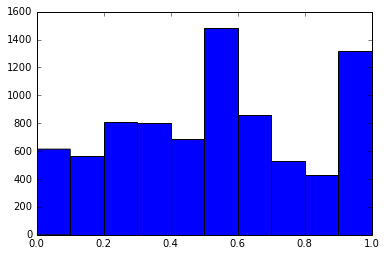

In [9]:
print "Distribution of answerability"
plt.hist(question_info['answerability'], bins=10)
plt.show()

Distribution of tags


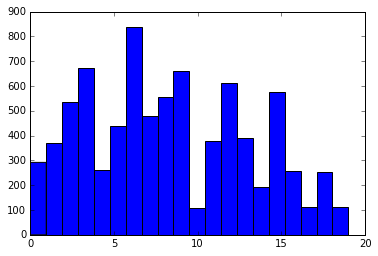

In [12]:
print "Distribution of tags"
plt.hist(question_info['tag'], bins=20)
plt.show()

Corelation between ease and popularity: 74.4624494725%


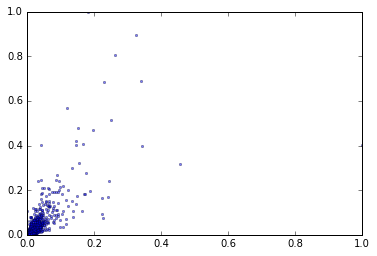

Variation of correlation between ease and popularity WRT answerability


/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


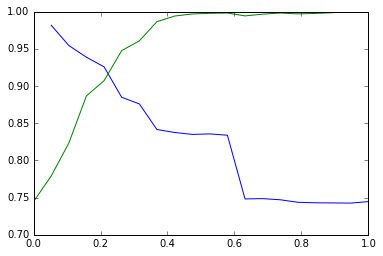

Answerability = 0.2 splits the dataset into 2 parts highly coreelated sets


In [13]:
ease_vs_popularity = np.corrcoef(question_info['ease'], question_info['popularity'])[ 0, 1]
print "Corelation between ease and popularity: {0}%".format(ease_vs_popularity * 100)
plt.plot(question_info['popularity'], question_info['ease'], "o", ms=2.5, alpha=0.5)
plt.show()

print "Variation of correlation between ease and popularity WRT answerability"
k = np.linspace(0, 1, num=20)
subs1 = lambda v: question_info[ question_info.answerability <= v  ]
subs2 = lambda v: question_info[ question_info.answerability > v   ]
ease_vs_popularity_1 = map(lambda v: np.corrcoef(subs1(v)['ease'], subs1(v)['popularity'])[ 0, 1], k)
ease_vs_popularity_2 = map(lambda v: np.corrcoef(subs2(v)['ease'], subs2(v)['popularity'])[ 0, 1], k)

plt.plot(k, ease_vs_popularity_1)
plt.plot(k, ease_vs_popularity_2)
plt.show()

print "Answerability = 0.2 splits the dataset into 2 parts highly coreelated sets"

Ease vs Popularity


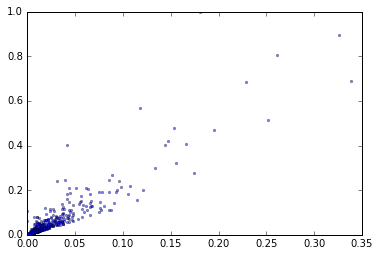

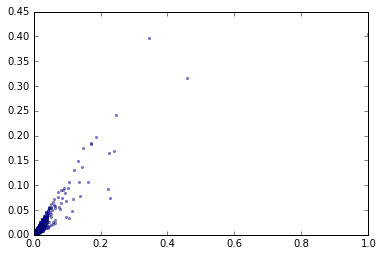

Distribution of tags


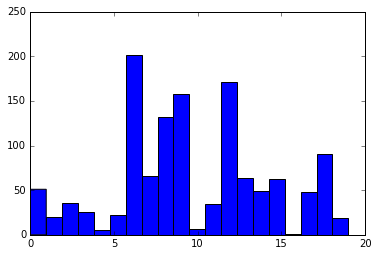

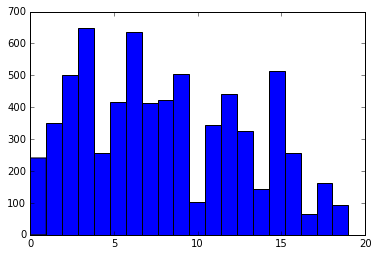

In [21]:
ds1 = subs1(0.2)
ds2 = subs2(0.2)

print "Ease vs Popularity"
plt.plot(ds1['popularity'], ds1['ease'], "o", ms=2.5, alpha=0.5)
plt.show()
plt.plot(ds2['popularity'], ds2['ease'], "o", ms=2.5, alpha=0.5)
plt.show()

print "Distribution of tags"
plt.hist(ds1['tag'], bins=20)
plt.show()
plt.hist(ds2['tag'], bins=20)
plt.show()



In [12]:
# Kmeans clustering


0.273996294009
